login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
                      open   high    low  close  volume     amount  adjustflag
time                                                                          
2018-05-02 09:35:00  25.51  26.00  25.51  26.00  283960  7317198.0           3
2018-05-02 09:40:00  26.02  26.02  25.79  25.98  283400  7348261.0           3
2018-05-02 09:45:00  25.98  26.05  25.88  25.97  208600  5417333.0           3
2018-05-02 09:50:00  25.99  26.20  25.91  26.08  235600  6145102.0           3
2018-05-02 09:55:00  26.08  26.10  25.98  26.10  105709  2751002.0           3
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                    

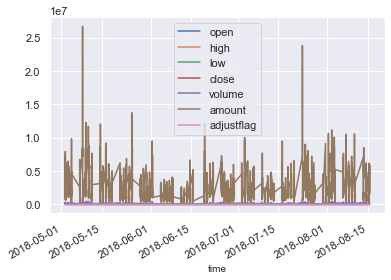

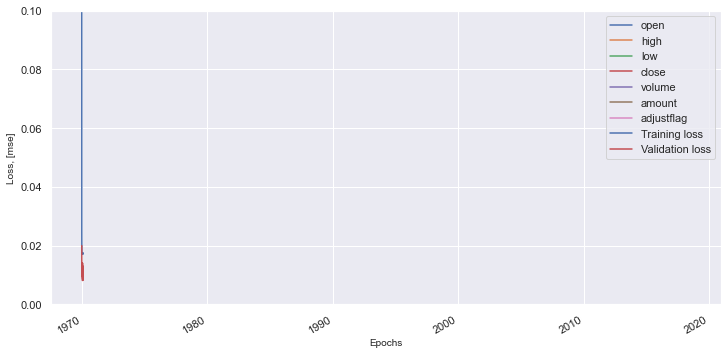

 1/50 [..............................] - ETA: 3s

D:\app\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


63/63 [==============================] - 0s 965us/step


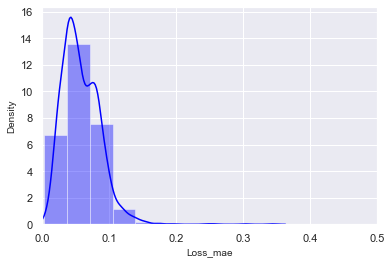

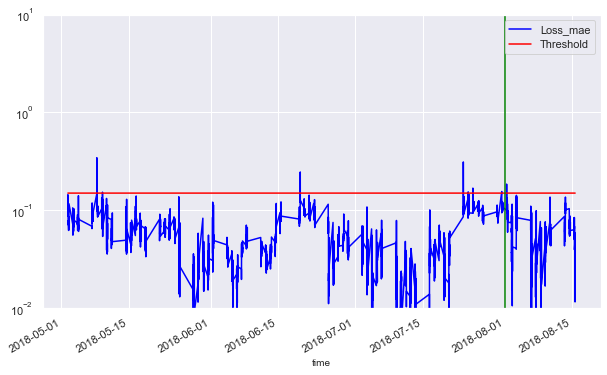

In [1]:
# %load  8.1-1 原始.py
import baostock as bs
import pandas as pd
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
from datetime import datetime

sns.set(color_codes=True)
import matplotlib.pyplot as plt

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取沪深A股历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
# 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
# 周月线指标：date,code,open,high,low,close,,amount,adjustflag,turn,pctChg
rs = bs.query_history_k_data_plus("sz.002025",
    "date,time,code,open,high,low,close,volume,amount,adjustflag",
    start_date='2018-05-01', end_date='2018-08-15',
    frequency="5", adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### 修改result数据类型 ####     
result = result.apply(pd.to_numeric,errors = 'ignore')  # 将dataframe中元素变为数值类型
result = result.drop(['date','code'],axis = 1)   # 删掉指定列，'date'和'code'为列名
result = result.set_index('time')                # 设置'time'列为指定行名
result.index = pd.to_datetime(result.index, format ='%Y%m%d%H%M%S%f')
print(result.head())
result.plot()


#时间戳更改
dataset_train = result['20180502093500':'20180629150000']
dataset_test = result['20180629150000':]
dataset_train.plot(figsize=(12, 6))


scaler = preprocessing.MinMaxScaler()  # 归一化

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),columns=dataset_train.columns,index=dataset_train.index)

# Random shuffle training data
X_train.sample(frac=1) # frac参数接收一个float类型数据，指定随机抽取行或列的比例

X_test = pd.DataFrame(scaler.transform(dataset_test),columns=dataset_test.columns,index=dataset_test.index)






# Build AutoEncoding model
def AutoEncoder_build(model, X_train, act_func):
    tf.random.set_seed(10)

    # act_func = 'elu'

    # Input layer:
    model = tf.keras.Sequential()  # Sequential() is a container that describes the network structure of the neural network, sequentially processing the model

    # First hidden layer, connected to input vector X.
    model.add(tf.keras.layers.Dense(10, activation=act_func,  # activation function
                                    kernel_initializer='glorot_uniform',  # Weight initialization
                                    kernel_regularizer=tf.keras.regularizers.l2(0.0),
                                    # Regularization to prevent overfitting
                                    input_shape=(X_train.shape[1],)
                                    )
              )

    model.add(tf.keras.layers.Dense(2, activation=act_func,
                                    kernel_initializer='glorot_uniform'))

    model.add(tf.keras.layers.Dense(10, activation=act_func,
                                    kernel_initializer='glorot_uniform'))

    model.add(tf.keras.layers.Dense(X_train.shape[1],
                                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse', optimizer='adam')  # 设置编译器

    print(model.summary())
    tf.keras.utils.plot_model(model, show_shapes=True)

    return model


model = tf.keras.Sequential()
model = AutoEncoder_build(model=model, X_train=X_train, act_func='elu')


def AutoEncoder_main(model, Epochs, BATCH_SIZE, validation_split):
    # Train model for 100 epochs, batch size of 10:
    # noise
    factor = 0.5
    X_train_noise = X_train + factor * np.random.normal(0, 1, X_train.shape)
    X_train_noise = np.clip(X_train_noise, 0., 1.)

    history = model.fit(np.array(X_train_noise), np.array(X_train),
                        batch_size=BATCH_SIZE,
                        epochs=Epochs,
                        shuffle=True, #应当是
                        validation_split=validation_split,  # Training set ratio
                        #                       validation_data=(X_train,X_train), # Validation set
                        verbose=1)

    return history


# Figure
def plot_AE_history(history):
    plt.plot(history.history['loss'],
             'b',
             label='Training loss')
    plt.plot(history.history['val_loss'],
             'r',
             label='Validation loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss, [mse]')
    plt.ylim([0, .1])
    plt.show()


history = AutoEncoder_main(model=model, Epochs=40, BATCH_SIZE=10, validation_split=0.05)

plot_AE_history(history)





X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred,
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10,
             kde= True,
            color = 'blue')
plt.xlim([0.0,.5])




X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred,
                      columns=X_test.columns)

X_pred.index = X_test.index
#需要知道上一行

threshod = 0.15
scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshod
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train,
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = threshod
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (10,6),ylim = [1e-2,1e1], color = ['blue','red'])

#scored.plot(logy=True,  figsize = (10,6),xlim = ['2018-07-15','2018-08-15'],ylim = [1e-2,1e1], color = ['blue','red'])
#plt.vlines(ymin=1e-2,ymax=1e1,label='vlines',color='green') 
#plt.vlines(['2018-08-01 15:00:00'],ymin=1e-2,ymax=1e1,label='vlines',color='green') 
plt.vlines(datetime.strptime('2018/08/01', '%Y/%m/%d'),ymin=1e-2,ymax=1e1,label='vlines',color='green') 
plt.show()






